In [4]:
#@title Download Data { display-mode: "form" }

import cv2
import dlib
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

import urllib.request

from sklearn import metrics
from scipy.spatial import distance
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm,tqdm_pandas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import re
import gdown
import keras

from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

# grab tools from our tensorflow and keras toolboxes!
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

warnings.filterwarnings("ignore")
def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)  
    return sms


dataset_url = 'https://drive.google.com/uc?id=1xFiYsULlQWWmi2Ai0fHjtApniP5Pscuf'
dataset_path = './ferdata.csv'
gdown.download(dataset_url, dataset_path, True)


dlibshape_url = 'https://drive.google.com/uc?id=17D3D89Gke6i5nKOvmsbPslrGg5rVgOwg'
dlibshape_path ='./shape_predictor_68_face_landmarks.dat'
gdown.download(dlibshape_url, dlibshape_path, True)


pureX_url = 'https://drive.google.com/uc?id=1CglpXodenZVrkaZehLtfykfQv8dcnfO9'
pureX_path = './pureX.npy'
gdown.download(pureX_url, pureX_path,True)


dataX_url = 'https://drive.google.com/uc?id=1sIJGxUM6rNBcWxucs6iynDepeKU1Q56p'
dataX_path = './dataX.npy'
gdown.download(dataX_url, dataX_path, True)

dataY_url = 'https://drive.google.com/uc?id=1Rfr0OP-hZO_UZfuOyMNR2RjNRAro85zE'
dataY_path = './dataY.npy'
gdown.download(dataY_url, dataY_path, True)


print ("Data Downloaded!")

def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = list(label_map.values())
  df_cm = pd.DataFrame(cm,index = labels,columns = labels)
  fig = plt.figure()
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5,3.5,4.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
 
  plt.show()
  plt.close()

def plot_graphs(history, best):
  
  plt.figure(figsize=[10,4])
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy across training\n best accuracy of %.02f'%best[1])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss across training\n best loss of %.02f'%best[0])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

label_map = {"0":"ANGRY","1":"HAPPY","2":"SAD","3":"SURPRISE","4":"NEUTRAL"}


predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
"""
Returns facial landmarks for the given input image path
"""
def get_landmarks(image):
  
  rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]
  landmarks = [(p.x, p.y) for p in predictor(image, rects[0]).parts()]
  return image,landmarks

def image_landmarks(image,face_landmarks):
  radius = -4
  circle_thickness = 1
  image_copy = image.copy()
  for (x, y) in face_landmarks:
    cv2.circle(image_copy, (x, y), circle_thickness, (255,0,0), radius)
    
  plt.imshow(image_copy, interpolation='nearest')
  plt.show()
def landmarks_edist(face_landmarks):
    e_dist = []
    for i in range(len(face_landmarks)):
        for j in range(len(face_landmarks)):
            if i!= j:
                e_dist.append(distance.euclidean(face_landmarks[i],face_landmarks[j]))
    return e_dist
  
def compare_learning(mlp, lm, cnn, vgg):
  
  plt.plot(vgg.history['val_accuracy'],)
  plt.plot(cnn.history['val_accuracy'])
  plt.plot(mlp.history['val_accuracy'],)
  plt.plot(lm.history['val_accuracy'])
  plt.ylabel('validitation accuracy')
  plt.xlabel('epoch')
  plt.legend(['cnn_transfer', 'cnn_scratch', 'mlp_pixels', 'mlp_landmarks'], bbox_to_anchor=[1,1])
  plt.xticks(range(0, epochs+1, 5), range(0, epochs+1, 5))
  plt.show()


Data Downloaded!


In [5]:
perceptron = Sequential()
n=2000
perceptron.add(Dense(1024, input_shape=(4556, ), activation='relu', kernel_initializer='glorot_normal'))
perceptron.add(Dense(512, activation='relu', kernel_initializer='glorot_normal'))
perceptron.add(Dense(5, activation='softmax'))
perceptron.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001), metrics=['mean_squared_error'])

In [6]:
perceptron_answer = Sequential()
perceptron_answer.add(Dense(units = 1024, input_shape = (4556,),kernel_initializer='glorot_normal',activation = 'relu'))
perceptron_answer.add(Dense(units = 512,kernel_initializer='glorot_normal' , activation = 'relu'))
perceptron_answer.add(Dense(units = 5, activation = 'softmax'))
    
perceptron_answer.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.001),
              metrics=['accuracy'])

if model_to_string(perceptron) == model_to_string(perceptron_answer):
  print('true')
else: 
  print('false')

false


In [7]:
epochs = 20
batch_size = 64
test_ratio = .1
n_labels = 5 

In [8]:
# load data 
dataX_pixels = np.load('pureX.npy')
dataY_pixels = np.load('dataY.npy')

### Converting labels to one-hot encoded labels


In [9]:
y_onehot = keras.utils.to_categorical(dataY_pixels, len(set(dataY_pixels)))


In [10]:
X_train, X_test, y_train, y_test = train_test_split(dataX_pixels, y_onehot, test_size=test_ratio, random_state=42)
pixel_scaler = StandardScaler()
pixel_scaler.fit(X_train)
X_train = pixel_scaler.transform(X_train)
X_test = pixel_scaler.transform(X_test)

## Simple mlp model


In [11]:
nuerons = 500
mlp_model = Sequential()
mlp_model.add(Dense(5000, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer='glorot_normal'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(350, activation='relu',kernel_initializer='glorot_normal'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(250, activation='relu',kernel_initializer='glorot_normal'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(100, activation='relu',kernel_initializer='glorot_normal'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(5, activation='softmax'))
perceptron.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001), metrics=['mean_squared_error'])


In [12]:
mlp_model.compile(loss=categorical_crossentropy, optimizer=SGD(lr=0.001), metrics=['accuracy'])          
checkpoint = ModelCheckpoint('best_mlp_model.h5', verbose=1, monitor='val_accuracy', save_best_only=True,  mode='auto')  
mlp_history = mlp_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, 
                            callbacks=[checkpoint], validation_data=(X_test, y_test), shuffle=True)

Epoch 1/20
272/282 [===========================>..] - ETA: 0s - loss: 2.1209 - accuracy: 0.2087
Epoch 00001: val_accuracy improved from -inf to 0.25800, saving model to best_mlp_model.h5
282/282 [==============================] - 2s 6ms/step - loss: 2.1107 - accuracy: 0.2097 - val_loss: 1.5809 - val_accuracy: 0.2580
Epoch 2/20
272/282 [===========================>..] - ETA: 0s - loss: 1.8179 - accuracy: 0.2206
Epoch 00002: val_accuracy improved from 0.25800 to 0.27800, saving model to best_mlp_model.h5
282/282 [==============================] - 1s 5ms/step - loss: 1.8162 - accuracy: 0.2209 - val_loss: 1.5802 - val_accuracy: 0.2780
Epoch 3/20
281/282 [============================>.] - ETA: 0s - loss: 1.7358 - accuracy: 0.2233
Epoch 00003: val_accuracy improved from 0.27800 to 0.28900, saving model to best_mlp_model.h5
282/282 [==============================] - 2s 5ms/step - loss: 1.7361 - accuracy: 0.2231 - val_loss: 1.5812 - val_accuracy: 0.2890
Epoch 4/20
279/282 [====================

In [13]:
mlp_performance = mlp_model.evaluate(X_test, y_test, batch_size=64)

32/32 [==============================] - 0s 3ms/step - loss: 1.5486 - accuracy: 0.3295


###Visualizing


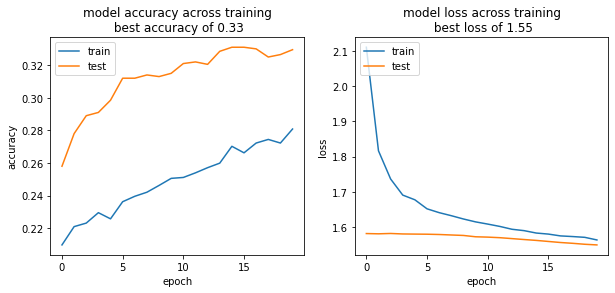

In [14]:
plot_graphs(mlp_history, mlp_performance); 

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Plotting the Confusion Matrix


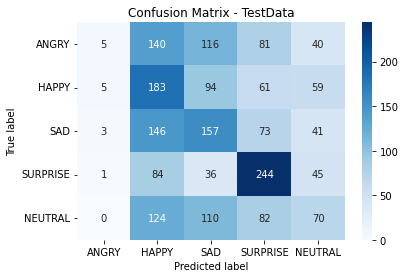

In [15]:
y_pred_mlp = mlp_model.predict_classes(X_test)
y_true = np.argmax(y_test,axis=1)
plot_confusion_matrix(y_true, y_pred_mlp)

In [16]:
dataX_lm = np.load('./dataX.npy')
dataY_lm = np.load('./dataY.npy')

y_onehot = keras.utils.to_categorical(dataY_lm, len(set(dataY_lm)))

In [17]:
X_train_lm, X_test_lm, y_train_lm, y_test_lm = train_test_split(dataX_lm, y_onehot, test_size=0.1, random_state=42)

lm_scaler = StandardScaler()
lm_scaler.fit(X_train_lm)
X_train_lm = lm_scaler.transform(X_train_lm)
X_test_lm = lm_scaler.transform(X_test_lm)

In [18]:
nuerons = 500
lm_model = Sequential()
lm_model.add(Dense(5000, input_shape=(X_train_lm.shape[1],), activation='relu', kernel_initializer='glorot_normal'))
lm_model.add(Dropout(0.5))
lm_model.add(Dense(500, activation='relu',kernel_initializer='glorot_normal'))
lm_model.add(Dropout(0.5))
lm_model.add(Dense(250, activation='relu',kernel_initializer='glorot_normal'))
lm_model.add(Dropout(0.5))
lm_model.add(Dense(5, activation='softmax'))

In [19]:
lm_model.compile(loss=categorical_crossentropy, optimizer=SGD(lr=0.001), metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_lm_model.h5', verbose=1, monitor='val_loss',save_best_only=True,  mode='auto')  
lm_history = lm_model.fit(X_train_lm, y_train_lm, batch_size=batch_size, epochs=epochs, 
                          verbose=1, callbacks=[checkpoint], validation_data=(X_test_lm, y_test_lm), shuffle=True)

Epoch 1/20
280/282 [============================>.] - ETA: 0s - loss: 1.9684 - accuracy: 0.2741
Epoch 00001: val_loss improved from inf to 1.36685, saving model to best_lm_model.h5
282/282 [==============================] - 2s 7ms/step - loss: 1.9664 - accuracy: 0.2748 - val_loss: 1.3669 - val_accuracy: 0.4330
Epoch 2/20
273/282 [============================>.] - ETA: 0s - loss: 1.6185 - accuracy: 0.3458
Epoch 00002: val_loss improved from 1.36685 to 1.34284, saving model to best_lm_model.h5
282/282 [==============================] - 2s 6ms/step - loss: 1.6155 - accuracy: 0.3469 - val_loss: 1.3428 - val_accuracy: 0.4490
Epoch 3/20
275/282 [============================>.] - ETA: 0s - loss: 1.5278 - accuracy: 0.3682
Epoch 00003: val_loss improved from 1.34284 to 1.33253, saving model to best_lm_model.h5
282/282 [==============================] - 3s 11ms/step - loss: 1.5298 - accuracy: 0.3670 - val_loss: 1.3325 - val_accuracy: 0.4425
Epoch 4/20
277/282 [============================>.] - E

### Evaluate model

In [20]:
lm_performance = lm_model.evaluate(x=X_test_lm,y=y_test_lm, batch_size=64)

32/32 [==============================] - 0s 4ms/step - loss: 1.2534 - accuracy: 0.4990


###Visualize accuracy and loss over training + display best model's performance

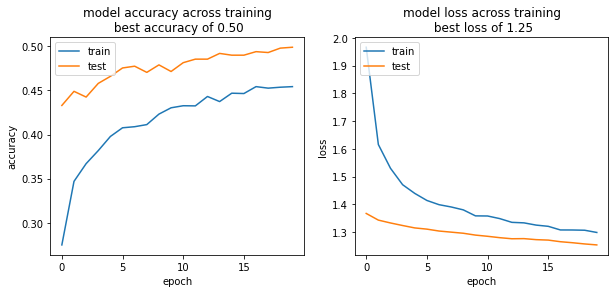

In [21]:

plot_graphs(lm_history, lm_performance); 

In [22]:
width, height = 48, 48

###Reshape the inputs

In [23]:
print(X_train.shape) 

(18000, 2304)


In [24]:
X_train_cnn = X_train.reshape(len(X_train),height,width)
X_test_cnn = X_test.reshape(len(X_test),height,width)

print(X_train_cnn.shape) 

(18000, 48, 48)


In [25]:
X_train_cnn = np.expand_dims(X_train_cnn,3)
X_test_cnn = np.expand_dims(X_test_cnn,3)

print(X_train_cnn.shape)

(18000, 48, 48, 1)


In [26]:
cnn_model = Sequential()
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(96, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(96, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(n_labels, activation='softmax'))

In [27]:
checkpoint = ModelCheckpoint('best_cnn_model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

cnn_model.compile(loss=categorical_crossentropy, optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train_cnn, y_train, batch_size=batch_size, epochs=epochs, verbose=1, 
                            callbacks=[checkpoint], validation_data=(X_test_cnn, y_test), shuffle=True)

Epoch 1/20
282/282 [==============================] - ETA: 0s - loss: 1.6517 - accuracy: 0.2797
Epoch 00001: val_loss improved from inf to 1.91161, saving model to best_cnn_model.h5
282/282 [==============================] - 4s 13ms/step - loss: 1.6517 - accuracy: 0.2797 - val_loss: 1.9116 - val_accuracy: 0.2370
Epoch 2/20
282/282 [==============================] - ETA: 0s - loss: 1.4731 - accuracy: 0.3549
Epoch 00002: val_loss improved from 1.91161 to 1.49165, saving model to best_cnn_model.h5
282/282 [==============================] - 3s 12ms/step - loss: 1.4731 - accuracy: 0.3549 - val_loss: 1.4917 - val_accuracy: 0.3760
Epoch 3/20
279/282 [============================>.] - ETA: 0s - loss: 1.3773 - accuracy: 0.4047
Epoch 00003: val_loss improved from 1.49165 to 1.32424, saving model to best_cnn_model.h5
282/282 [==============================] - 3s 12ms/step - loss: 1.3774 - accuracy: 0.4046 - val_loss: 1.3242 - val_accuracy: 0.4765
Epoch 4/20
279/282 [============================>.

###Evaluate the model


In [28]:
cnn_performance = cnn_model.evaluate(x=X_test_cnn,y=y_test_lm, batch_size=64)
cnn_performance

32/32 [==============================] - 0s 5ms/step - loss: 0.9060 - accuracy: 0.6365


[0.9059977531433105, 0.6365000009536743]



```
# This is formatted as code
```

#Even better model pre-ran then frozen to change weights


In [29]:

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.applications.vgg16 import VGG16

vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (48, 48, 3))

vgg_model = Sequential()
vgg_model.add(vgg_expert)

vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(5, activation = 'sigmoid'))

vgg_model.compile(loss = 'categorical_crossentropy', 
          optimizer = optimizers.SGD(lr=1e-4, momentum=0.95), 
          metrics=['accuracy'])

X_TRAIN = np.array([np.transpose(np.array([X_train_cnn[ix].squeeze() for i in range(3)]), (1,2,0)) for ix in range(len(X_train))])
X_TEST = np.array([np.transpose(np.array([X_test_cnn[ix].squeeze() for i in range(3)]), (1,2,0)) for ix in range(len(X_test))])

vgg_history = vgg_model.fit(X_TRAIN, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[checkpoint],
          validation_data=(X_TEST, y_test),
          shuffle=True)

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/20
282/282 [==============================] - ETA: 0s - loss: 1.5088 - accuracy: 0.3142
Epoch 00001: val_loss did not improve from 0.90077
282/282 [==============================] - 18s 64ms/step - loss: 1.5088 - accuracy: 0.3142 - val_loss: 1.3262 - val_accuracy: 0.4525
Epoch 2/20
281/282 [============================>.] - ETA: 0s - loss: 1.2812 - accuracy: 0.4670
Epoch 00002: val_loss did not improve from 0.90077
282/282 [==============================] - 18s 62ms/step - loss: 1.2812 - accuracy: 0.4669 - val_loss: 1.1447 - val_accuracy: 0.5330
Epoch 3/20
281/282 [============================>.] - ETA: 0s - loss: 1.1499 - accuracy: 0.5315
Epoch 00003: val_loss did not improve from 0.90077
282/282 [==============================] - 17s 62ms/step - loss: 1.1498 - accuracy: 0.5314 - val_loss: 1.0427 - val_accuracy: 0.5710
Epoch 4/20
281/282 [============================>.] - ETA: 0s - loss: 1.0595 - accuracy: 0.5701

###Comparing data between models (cnn_transfer is best, cnn_scratch is second)


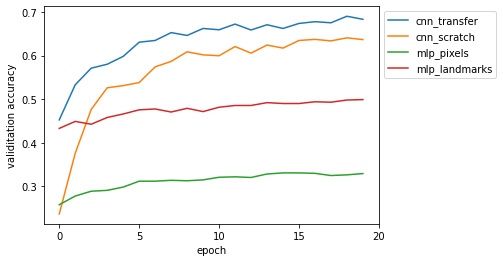

In [30]:
compare_learning(mlp_history, lm_history, cnn_history, vgg_history)